## References

- https://medium.com/analytics-vidhya/play-store-app-reviews-textual-data-topic-modelling-using-lda-f24bdbd2910d

In [14]:
# !pip install google_play_scraper
# !pip install sklearn

## Libraries needed

In [2]:
import pandas as pd
from google_play_scraper.features.reviews import Sort, reviews_all, reviews
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## Mining app review from Bolt (Google Play Store)

In [3]:
result = reviews_all('ee.mtakso.client',sleep_milliseconds=0,lang='en', country='us')

## Create dataframe of the reviews

In [6]:
df = pd.DataFrame(result)
unique_users  = len(df['userName'].unique())
unknown_users = len(df[df['userName']=='A Google user'])
total_reviews = len(df)
mean = df['score'].mean()
print(f'Total textual reviews: {len(result)} \n')
print(f'Total unique users : {unique_users}')
print(f'Total unknown users: {unknown_users}')
print(f'Total users who gave multiple reviews: {total_reviews - unique_users - unknown_users}\n')
print(f'Average rating for this app based on the textual reviews: {round(mean,2)} \n')

Total textual reviews: 135334 

Total unique users : 127758
Total unknown users: 5953
Total users who gave multiple reviews: 1623

Average rating for this app based on the textual reviews: 4.26 



## Extract all reviews with rating below 4

In [7]:
df_tm = df[df['score']<=3]
df_tm = df_tm[df_tm.content.str.len()>=30]
print(f'Remaining textual reviews: {len(df_tm)} \n')


Remaining textual reviews: 18342 



## Get Relevant Columns for Topic Modelling


In [8]:
df_tm = df_tm[['reviewId','content']].drop_duplicates()
df_tm.dropna(inplace=True)
df_tm = df_tm.reset_index().drop(columns='index')
print(f'Remaining textual reviews: {len(df_tm)} \n')


Remaining textual reviews: 18342 



## Create document term matrix of the reviews

In [9]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(df_tm['content'])
dtm

<18342x9394 sparse matrix of type '<class 'numpy.int64'>'
	with 232873 stored elements in Compressed Sparse Row format>

## Using LDA for topic modelling

In [10]:
LDA = LatentDirichletAllocation(n_components=5,random_state=1)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=1)

### Extract the topics and corresponding top20 (high frequency) words


In [11]:
for index,topic in enumerate(LDA.components_):
    print(f'topic #{index} : ')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])

topic #0 : 
['10', 'work', 'doesn', 'away', 'just', 'wait', 'wrong', 'trip', 'request', 'drivers', 'cancel', 'waiting', 'times', 'pick', 'minutes', 'location', 'ride', 'time', 'app', 'driver']
topic #1 : 
['pay', 'time', 'taxify', 'just', 'phone', 'got', 'promo', 'use', 'don', 'support', 'payment', 'bolt', 'money', 'charged', 'driver', 'trip', 'price', 'card', 'ride', 'app']
topic #2 : 
['blocked', 'bad', 'using', 'worst', 'taxify', 'just', 'trip', 'ride', 'pay', 'money', 'card', 'uber', 'support', 'account', 'use', 'bolt', 'customer', 'driver', 'service', 'app']
topic #3 : 
['cancel', 'know', 'uber', 'service', 'use', 'need', 'cars', 'price', 'just', 'time', 'like', 'bad', 'rude', 'prices', 'driver', 'good', 'don', 'bolt', 'app', 'drivers']
topic #4 : 
['cu', 'pe', 'el', 'en', 'mi', 'mai', 'по', 'за', 'nie', 'что', 'na', 'ca', 'se', 'que', 'sa', 'nu', 'на', 'la', 'si', 'не']


## Combine the topic modelling results with the base dataset

In [12]:
topic_results = LDA.transform(dtm)
df_topic_results = pd.DataFrame(topic_results, columns=[
    '0_Booking',
    '1_Payment/Promo' ,
    '2_App'            ,
    '3_Services'  ,
    '4_Others' 
])
df_result = pd.merge(df_tm, df_topic_results,  how='inner', left_index=True, right_index=True )
df_output = pd.merge(df, df_result,  how='left', on=[ 'reviewId','content' ])

df_output.to_csv('app_reviews_bms.csv')

## Example DataViz using [Tableau](https://public.tableau.com/profile/pankaj.kumar.shukla#!/vizhome/AppReviews_v2/GooglePlayStoreappreviewanalysis)


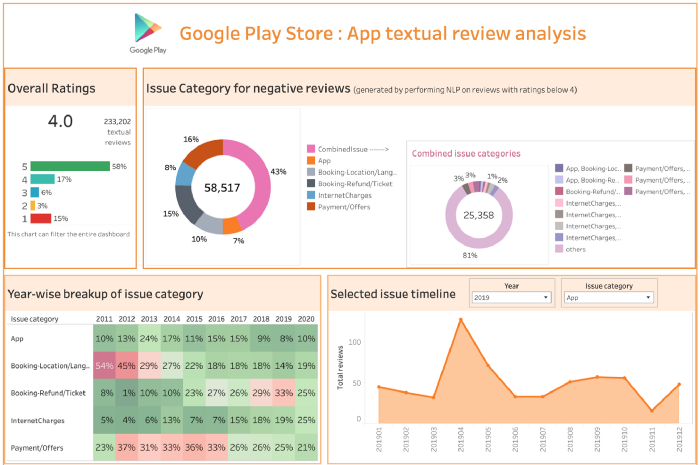



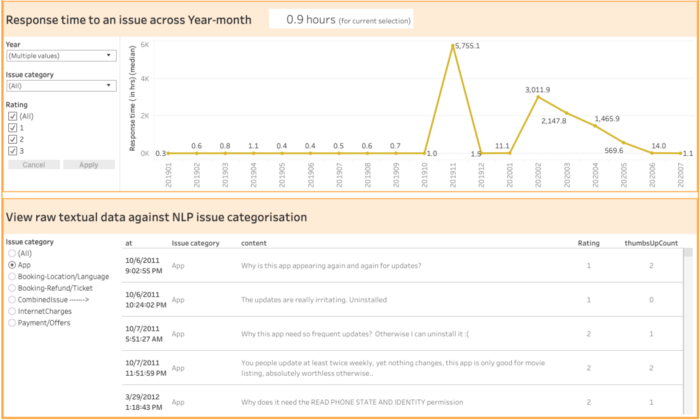